# This is a tutorial notebook for the `auto_oo` package

The goal of this package is to provide the user with cost functions representing ground state energies of electronic structure Hamiltonians, that are auto-differentiable with respect to both quantum circuit ($\vec{\theta}$) and classical orbital parameters ($\vec{\kappa}$). See [our paper](https://arxiv.org/abs/2304.06070) and the other example notebook for more applications of this code.

## Installation
First, create an anaconda or pip environment and install PyTorch, for example locally in a cpu-only installation.\
Installation instructions can be found in the [Get Started](https://pytorch.org/get-started/locally/) section of the PyTorch website.
For now, an additional dependency is jax, of which the cpu version can be easily installed via pip. See the [Installation instruction](https://github.com/google/jax#installation).
The code is build such that you can use them interchangably.
Finally, install this package by cloning the repo, then use `pip install -e .` in the cloned directory.
### Dependencies
We have the following dependencies:
- numpy
- pennylane (version >= 0.31.1, where the orbital-rotation bug is fixed. See [here](https://github.com/PennyLaneAI/pennylane/commit/5c87d88dfb36e8a173c97378e01ed6f40960d317).
- scipy
- openfermion
- pyscf
- pytorch
- jax

In this tutorial, we use [cirq](https://github.com/quantumlib/cirq) to visualize states using Dirac notation.

For now, it is only interfaced with PySCF to retrieve molecular structure info.

The updated version (0.31.1) of Pennylane is needed if you want to use np_fabrics ansatz.

## Code structure

```
auto_oo
├── ansatze
│   ├── __init__.py
│   ├── kUpCCD.py -│ Different Ansätze that are modified from Pennylane to exclude single excitations,
│   └── uccd.py   -│ as we can deal with them in the classical orbital-optimization.
├── __init__.py
├── moldata_pyscf.py - Interface to pyscf for extracting integrals and overlap matrices
│                      (and optionally do Hartree-Fock or CASSCF to compare results)
├── pqc.py - Here we generate parameterized quantum circuits. There is a method to extract states
│            and 1- and 2-Reduced Density Matrices (RDMs)
├── oo_energy.py - Here the main code lives. This class is used to calculate auto-differentiable
│                  energies from 1- and 2-RDMs. It can compute analytical gradients and Hessians
│                  with respect to orbital rotations. It has a method to perform orbital optimization
│                  using the newton_raphson module. It is agnostic to the method used to retrieve RDMs.
├── oo_pqc.py - A child of the OO_energy class. Here the Parameterized circuit and the oo_energy
│               come together and with this the user is able to extract orbital and quantum
│               circuit parameter gradients and (composite) Hessians. It has a method to perform
│               full (circuit and orbital) optimization with Newton-Raphson steps.
├── noisy_oo_pqc.py Adaptation of the above class to include noisy gradients and Hessians used
│                   in our sampling noise simulations.
└── utils
    ├── active_space.py - Functions for computing active space integrals and fermionic operators
    ├── __init__.py
    ├── miscellaneous.py - Some miscellaneous functions to enable sparse matrices
    └── newton_raphson.py - Performs single Newton-Raphson steps (optionally with regularization) using
                            gradients and Hessians
```

In [1]:
import auto_oo
import pennylane as qml
import numpy as np
import torch
import openfermion
import cirq
import matplotlib.pyplot as plt

# Making a parameterized quantum circuit

To define the electronic ground state energy of a particular molecule, we need two building blocks to start:
- A parameterized quantum circuit
- A model of the molecule, containing molecular data

First let us define the parameterized quantum circuit. For our purposes, we want a class that takes as input the active space size and a PennyLane device. For more information how pennylane handles quantum circuits, see for example https://pennylane.ai/qml/demos/tutorial_qubit_rotation.html.

These are the parameters we will try:

In [2]:
ncas = 3 # Number of active orbitals
nelecas = 4 # Number of active electrons
dev = qml.device('default.qubit', wires=2*ncas)

The `auto_oo.Parameterized_circuit` class has as main goal to extract one- and two-RDMs given a set of quantum circuit parameters. It natively supports multiple standard Ansatzes, like UCC(S)D and Number-preserving Fabrics. One can also input a custom `pennylane.QNode` that outputs a quantum state, see the documentation of the class for more information. Both the parameter vector and output state are `torch.Tensor` objects, that are compatible with automatic differentation in pytorch.

In [8]:
ansatz = 'np_fabric' # One of the native ansatze. See https://docs.pennylane.ai/en/stable/code/api/pennylane.GateFabric.html
n_layers = 2 # Number of layers in the GateFabric ansatz

In [9]:
pqc = auto_oo.Parameterized_circuit(ncas, nelecas, dev, ansatz=ansatz, n_layers=n_layers)

A small detail: set the default input to double precision. This will be automatically fixed in a later version.

In [10]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [11]:
# Print the circuit for a random theta vector.
theta_test = torch.Tensor([np.random.uniform(0., 2*np.pi) for x in range(pqc.theta_shape)])
print(pqc.draw_circuit(theta_test))

0: ──X─╭G²(0.00)─╭OrbitalRotation(0.00)──────────────────────────────────╭G²(1.10)
1: ──X─├G²(0.00)─├OrbitalRotation(0.00)──────────────────────────────────├G²(1.10)
2: ──X─├G²(0.00)─├OrbitalRotation(0.00)─╭G²(3.72)─╭OrbitalRotation(2.82)─├G²(1.10)
3: ──X─╰G²(0.00)─╰OrbitalRotation(0.00)─├G²(3.72)─├OrbitalRotation(2.82)─╰G²(1.10)
4: ─────────────────────────────────────├G²(3.72)─├OrbitalRotation(2.82)──────────
5: ─────────────────────────────────────╰G²(3.72)─╰OrbitalRotation(2.82)──────────

──╭OrbitalRotation(2.74)──────────────────────────────────┤  State
──├OrbitalRotation(2.74)──────────────────────────────────┤  State
──├OrbitalRotation(2.74)─╭G²(4.68)─╭OrbitalRotation(3.95)─┤  State
──╰OrbitalRotation(2.74)─├G²(4.68)─├OrbitalRotation(3.95)─┤  State
─────────────────────────├G²(4.68)─├OrbitalRotation(3.95)─┤  State
─────────────────────────╰G²(4.68)─╰OrbitalRotation(3.95)─┤  State


To extract the state from the pqc class, call the attribute `qnode` that returns a `torch.Tensor`.

In [12]:
state = pqc.qnode(theta_test)
# We can visualize the state in dirac notation with the help of cirq. For this, convert it to a numpy array first:
print(cirq.dirac_notation(state.detach().numpy(), decimals=4))

-0.2403|001111⟩ + 0.1283|011011⟩ + 0.032|011110⟩ - 0.1283|100111⟩ - 0.032|101101⟩ + 0.7141|110011⟩ - 0.0804|110110⟩ + 0.0804|111001⟩ + 0.6201|111100⟩


From this state, we can extract the spin-restricted 1- and 2-RDMS, defined by:

$$
\begin{align}
    \gamma_{pq}(\boldsymbol{\theta}) &= \langle\psi(\boldsymbol{\theta})|E_{pq}|\psi(\boldsymbol{\theta})\rangle\\
    \Gamma_{pqrs}(\boldsymbol{\theta}) &= \langle\psi(\boldsymbol{\theta})|e_{pqrs}|\psi(\boldsymbol{\theta})\rangle
\end{align}
$$

where $E_{pq} = \sum_\sigma a_{p\sigma}^\dagger a_{q\sigma}$ and $e_{pqrs} = \sum_{\sigma \tau} a_{p\sigma}^\dagger a_{r\tau}^\dagger a_{s\tau} a_{q\sigma} = E_{pq}E_{rs} - \delta_{qr}E_{ps}$.

From these, we will later define the energy cost-function.

We can visualize the 1-RDM using matplotlib

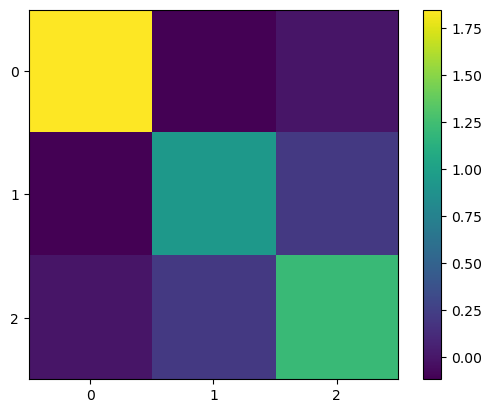

In [13]:
import warnings
warnings.simplefilter("ignore", UserWarning) # Ignore a pytorch warning about sparse matrices being in beta state

one_rdm, two_rdm = pqc.get_rdms_from_state(state)

plt.imshow(one_rdm)
plt.yticks(list(range(ncas)))
plt.xticks(list(range(ncas)))
plt.colorbar()
plt.show()

# Make a cost-function with a molecular Hamiltonian

## PySCF interface

Lets use the molecule formaldimine as an example. The `auto_oo` package is interfaced with PySCF to extract molecular properties using `auto_oo.Moldata_pyscf`. ![picture](formaldimine.png)

In [14]:
def get_formal_geo(alpha, phi):
    variables = [1.498047, 1.066797, 0.987109, 118.359375] + [alpha, phi]
    geom = """
                    N
                    C 1 {0}
                    H 2 {1}  1 {3}
                    H 2 {1}  1 {3} 3 180
                    H 1 {2}  2 {4} 3 {5}
                    """.format(*variables)
    return geom

In [15]:
alpha = 140
phi = 80
basis = 'sto-3g' # You can try a bigger basis set if you want
mol = auto_oo.Moldata_pyscf(get_formal_geo(alpha,phi), basis)

In [16]:
print(get_formal_geo(alpha, phi))


                    N
                    C 1 1.498047
                    H 2 1.066797  1 118.359375
                    H 2 1.066797  1 118.359375 3 180
                    H 1 0.987109  2 140 3 80
                    


(13, 13)
(13, 13, 13, 13)


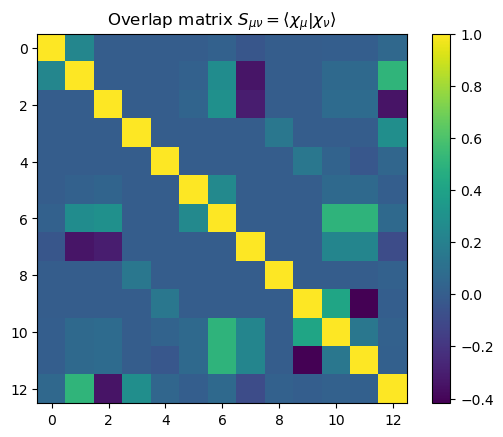

In [17]:
# This class stores the integrals and the overlap matrix for example:
print(mol.int1e_ao.shape)
print(mol.int2e_ao.shape)
plt.title(r'Overlap matrix $S_{\mu \nu} = \langle \chi_\mu | \chi_\nu \rangle$')
plt.imshow(mol.overlap)
plt.colorbar()
plt.show()

We can also run Hartree-Fock, CASCI or CASSCF:

In [18]:
mol.run_rhf()
mol.run_casci(ncas, nelecas)
mol.run_casscf(ncas, nelecas)

In [19]:
print(f'Hartree-Fock energy: {mol.hf.e_tot:.6f}')
print(f'CASCI energy:        {mol.casci.e_tot:.6f}')
print(f'CASSCF energy:       {mol.casscf.e_tot:.6f}')

Hartree-Fock energy: -92.663722
CASCI energy:        -92.736706
CASSCF energy:       -92.749954


## Orbital Optimized energies and Hamiltonians

To extract Hamiltonian and energies in different MO basis, feed it into the `OO_energy` class. If you the user does not input any MO coefficients, it defaults to Hartree-Fock MOs.

In [20]:
oo_energy = auto_oo.OO_energy(mol, ncas, nelecas)

In [21]:
# Test if the MOs are indeed HF:
np.allclose(oo_energy.mo_coeff.detach().numpy(), mol.hf.mo_coeff)
# We use the .detach().numpy() method to convert a PyTorch Tensor to a numpy array

True

The most important functionality of `auto_oo` is to give an auto-differentiable energy cost function in an active space. The energy will both depend on the 1- and 2-RDMs and the Molecular coefficients defined by the MOs. The set of MOs are in general written as:

$$
\phi_p (C, \mathbf{R}) = \sum_{\mu} \chi_\mu(\mathbf{R}) C_{\mu p}
$$

We can transform these MOs with a unitary matrix, parameterized exponentially by $\kappa$:

$$
\phi^\prime_q = \sum_p \phi_p [e^{-\kappa}]_{pq}
$$

where $\kappa$ is an anti-symmetric matrix with $N(N-1)/2$ parameters. This amounts to transforming $C\rightarrow C e^{-\kappa}$.

The total energy is given by:

$$
    E(C, \gamma, \Gamma) = E_{\rm nuc} + E_{\rm core}(C) +
    \sum_{tu}\tilde{h}_{tu}(C) \gamma_{tu} +
    \sum_{tuvw} g_{tuvw}(C) \Gamma_{tuvw}
$$

where $E_{core}$ is the mean-field energy of the core (doubly-occupied) orbitals, $\tilde{h}_{pq}$ is contains the active one-body terms plus the mean-field interaction of core-active orbitals and $g_{pqrs}$ are the active integrals in chemist ordering. 

This function is then differentiable to a transformation of the MOs $\kappa$, and the one- and two-RDMs $\gamma$ and $\Gamma$. The single gradient and hessian with respect to orbital rotations,  $\frac{\partial E}{\partial \kappa_{pq}}$ and $\frac{\partial^2 E}{\partial \kappa_{pq} \partial \kappa_{rs}}$, can also be obtained analytically. Of the total parameter vector $\kappa$, rotations from occupied to occupied and virtual to virtual are redundant and set to zero.

We can compute the active space energy with the RDMs from the `pqc` class. In that case, they are dependent on the circuit parameter vector $\boldsymbol{\theta}$.

In [23]:
energy_random_theta = oo_energy.energy_from_mo_coeff(oo_energy.mo_coeff, one_rdm, two_rdm).item()
print(f'Energy with a random theta: {energy_random_theta:.6f}')

Energy with a random theta: -92.502191


Of course, the energy with a random theta is not great. While the `auto_oo` package is really only meant to give you primitives of energies and parameter derivatives, there is a method included to optimize the orbitals, that uses the `newton_raphson` module. For more information, we refer you to the documentation of the `newton_raphson` module. We can optimize the orbitals for this specific state by calling the `orbital_optimization` method.

In [25]:
energy_l = oo_energy.orbital_optimization(one_rdm, two_rdm)

iter = 000, energy = -92.546873671912
iter = 001, energy = -92.550823734195
iter = 002, energy = -92.560821320082
iter = 003, energy = -92.590866341963
iter = 004, energy = -92.613945393479
iter = 005, energy = -92.616055107384
iter = 006, energy = -92.616068152030
iter = 007, energy = -92.616068153120


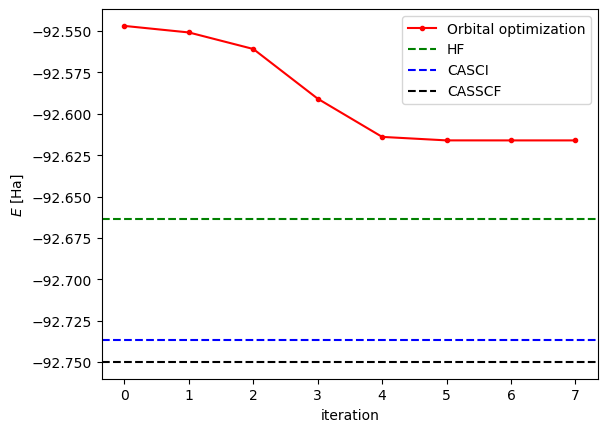

In [26]:
plt.plot(energy_l, '.-r', label='Orbital optimization')
plt.axhline(mol.hf.e_tot, ls='--', c='g', label='HF')
plt.axhline(mol.casci.e_tot, ls='--', c='b', label='CASCI')
plt.axhline(mol.casscf.e_tot, ls='--', c='k', label='CASSCF')
plt.xlabel('iteration')
plt.ylabel(r'$E$ [Ha]')
plt.legend()
plt.show()

## Optimizing a circuit 
While this gives us optimized orbitals for a random theta, a user usually often interested in optimizing he parameters as well. Lets do it for the Hartree-Fock orbitals. As this is not functionality that is inside `auto_oo`, we can import from PyTorch a gradient descent optimizer. 

First, extract the active space Hamiltonian

In [27]:
# We can extract the Hamiltonian as an openfermion FermionOperator for the Hartree-Fock orbitals
c0, c1, c2 = oo_energy.get_active_integrals(torch.from_numpy(mol.hf.mo_coeff))
fermionic_cas_hamiltonian = auto_oo.fermionic_cas_hamiltonian(c0, c1, c2)

In [28]:
# Compute the eigenvalues to make sure we have the correct Hamiltonian
fch_energies = openfermion.eigenspectrum(fermionic_cas_hamiltonian)
e_0 = fch_energies[0]
print(f'Based on HF orbitals, the CASCI ground state energy is: {e_0:.6f}')
print(f'CASCI energy from PySCF:                                {mol.casci.e_tot:.6f}')

Based on HF orbitals, the CASCI ground state energy is: -92.736706
CASCI energy from PySCF:                                -92.736706


Now we can convert it to a pennylane observable to measure with a `qml.qnode`. First convert it to a QubitOperator with the Jordan-Wigner transformation.

In [29]:
qubit_cas_hamiltonian = openfermion.jordan_wigner(fermionic_cas_hamiltonian)

In [30]:
pennylane_cas_hamiltonian = qml.qchem.import_operator(qubit_cas_hamiltonian)

For the ansatz lets choose the same one that is inside the `pqc` class, the GateFabric ansatz. We can optimize it with the Adam optimizer from PyTorch. This automatically computes the gradient at every step. It can do so quickly because of automatic-differentation of the circuit.

In [31]:
@qml.qnode(dev, interface='torch', diff_method='backprop')
def cost_function(theta):
    """ Outputs NP fabric ansatz state"""
    qml.GateFabric(theta,
                   wires=pqc.wires, init_state=pqc.hfstate, include_pi=False)
    return qml.expval(pennylane_cas_hamiltonian)

In [32]:
theta = torch.zeros(pqc.full_theta_shape)
theta.requires_grad = True

energy_init = cost_function(theta).item()
print(f'Zero parameters give us an energy of:       {energy_init:.6f}')
print(f'Should be equal to the Hartree-Fock energy: {mol.hf.e_tot:.6f}')

Zero parameters give us an energy of:       -92.663722
Should be equal to the Hartree-Fock energy: -92.663722


In [33]:
# Define hyperparameters and optimizer of the VQE
max_iterations = 100
conv_tol = 1e-8
stepsize = 0.03
e_min = 1e99
opt = torch.optim.Adam([theta],lr=stepsize)

# Save results in
opt_trajectory = [energy_init]
theta_trajectory = [theta.detach().clone()]

In [34]:
for n in range(max_iterations):
    # At every step, clear the gradient and do a backward pass to compute
    # the gradient. Then perform one step of the Adam optimizer.
    opt.zero_grad()
    loss = cost_function(theta)
    loss.backward()
    opt.step()

    curr_energy = cost_function(theta).item()

    print('iter, e =', n, curr_energy)
    opt_trajectory.append(curr_energy)
    theta_trajectory.append(theta.detach().clone())

    if curr_energy < e_min:
        e_min = curr_energy
        n_min = n
        theta_min = theta.detach().clone()
    
    # Convergence condition
    if n > 1:
        if (np.abs(opt_trajectory[-1] - opt_trajectory[-2])\
            < conv_tol):
            print("\nVQE converged")
            print(f'VQE energy: {opt_trajectory[-1]:.6f}')
            print(f'CASCI energy:  {mol.casci.e_tot:.6f}')
            break


iter, e = 0 -92.66637216451433
iter, e = 1 -92.66870321172385
iter, e = 2 -92.6706956343295
iter, e = 3 -92.67259714066249
iter, e = 4 -92.67433510170314
iter, e = 5 -92.67585618080426
iter, e = 6 -92.67714338218276
iter, e = 7 -92.67827065721652
iter, e = 8 -92.67937801078979
iter, e = 9 -92.68054015697639
iter, e = 10 -92.68177226119693
iter, e = 11 -92.68310095592636
iter, e = 12 -92.68457882027793
iter, e = 13 -92.68625363121787
iter, e = 14 -92.6881419819804
iter, e = 15 -92.69023050784078
iter, e = 16 -92.69249073709399
iter, e = 17 -92.6948909267111
iter, e = 18 -92.69739971446761
iter, e = 19 -92.69998449952188
iter, e = 20 -92.70260924104677
iter, e = 21 -92.70523441757305
iter, e = 22 -92.70781992496056
iter, e = 23 -92.71033009525632
iter, e = 24 -92.71273824128687
iter, e = 25 -92.71502714031337
iter, e = 26 -92.71718420494354
iter, e = 27 -92.71919625758122
iter, e = 28 -92.72105119911346
iter, e = 29 -92.72274547958064
iter, e = 30 -92.72428673872143
iter, e = 31 -92.7256

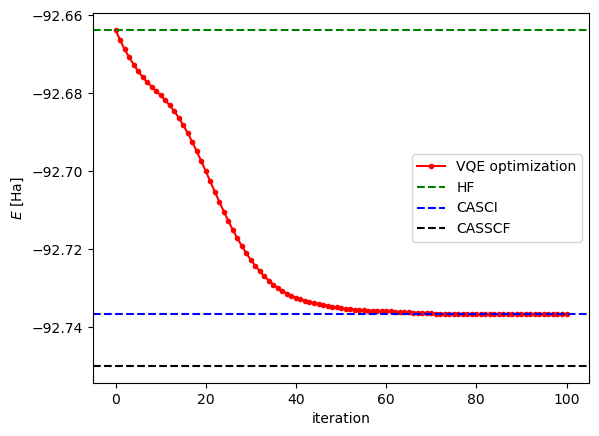

In [35]:
plt.plot(opt_trajectory, '.-r', label='VQE optimization')
plt.axhline(mol.hf.e_tot, ls='--', c='g', label='HF')
plt.axhline(mol.casci.e_tot, ls='--', c='b', label='CASCI')
plt.axhline(mol.casscf.e_tot, ls='--', c='k', label='CASSCF')
plt.xlabel('iteration')
plt.ylabel(r'$E$ [Ha]')
plt.legend()
plt.show()

# Put the parameterized quantum circuit and differentiable cost function together with `OO_pqc`

If you want a cost function dependent on both quantum circuit parameters $\theta$ and orbital rotation parameters $\kappa$, use the `OO_energy` child class `OO_pqc`. With this you can compute gradients to both parameters, and including composite Hessians.

In [36]:
oo_pqc = auto_oo.OO_pqc(pqc, mol, ncas, nelecas, freeze_active=True)

We can now retrieve the full Hessian to all the parameters. It can be written as:

$$
\begin{align}
    \nabla_{(\boldsymbol{\theta},\boldsymbol{\kappa})} E 
    &= (\nabla_{\boldsymbol{\theta}}E, \nabla_{\boldsymbol{\kappa}} E)  \label{eq:composite-gradient}
    \\
    \nabla^2_{(\boldsymbol{\theta},\boldsymbol{\kappa})} E 
    &= 
    \begin{bmatrix}
        \nabla^2_{\boldsymbol{\theta}}E 
        & \nabla_{\boldsymbol{\kappa}}\nabla_{\boldsymbol{\theta}} E\\
        (\nabla_{\boldsymbol{\kappa}}\nabla_{\boldsymbol{\theta}} E)^\intercal
        & \nabla^2_{\boldsymbol{\kappa}} E 
    \end{bmatrix}.  \label{eq:composite-hessian}
\end{align}
$$

The off-diagonal blocks are computed by auto-differentation of the analytical gradient of $\kappa$ w.r.t. $\theta$ 

In [37]:
print("Number of thetas:", pqc.theta_shape)
print("Number of kappas:", oo_pqc.n_kappa)
print("Shape of the full Hessian matrix:", oo_pqc.full_hessian(theta_test).shape)

Number of thetas: 6
Number of kappas: 54
Shape of the full Hessian matrix: torch.Size([60, 60])


To perform full optimization (i.e. OO-VQE) of both circuit and orbital parameters with the Newton-raphson method, we can call the `full_optimizaton` method of `OO_pqc`.

In [38]:
theta_zero = pqc.init_zeros()
energy_l, theta_l, kappa_l, oao_mo_coeff_l, hess_eig_l = oo_pqc.full_optimization(theta_zero)

iter = 000, energy = -92.663721935561
iter = 001, energy = -92.703329345161
iter = 002, energy = -92.726531309276
iter = 003, energy = -92.728970171942
iter = 004, energy = -92.735894219635
iter = 005, energy = -92.748386743894
iter = 006, energy = -92.748582756633
iter = 007, energy = -92.749167712992
iter = 008, energy = -92.749221860108
iter = 009, energy = -92.749234092023
iter = 010, energy = -92.749252867310
iter = 011, energy = -92.749280554700
iter = 012, energy = -92.749414901043
iter = 013, energy = -92.749635672341
iter = 014, energy = -92.749830431066
iter = 015, energy = -92.749942259795
iter = 016, energy = -92.749950244167
iter = 017, energy = -92.749953629340
iter = 018, energy = -92.749953681391
iter = 019, energy = -92.749953681394
optimization finished.
E_fin = -92.74995368139423


Indeed, we should have reached the CASSCF energy, given that the ansatz can exactly represent the ground state:

In [39]:
print("\nOO-VQE converged")
print(f'OO-VQE energy: {energy_l[-1]:.6f}')
print(f'CASSCF energy: {mol.casscf.e_tot:.6f}')


OO-VQE converged
OO-VQE energy: -92.749954
CASSCF energy: -92.749954


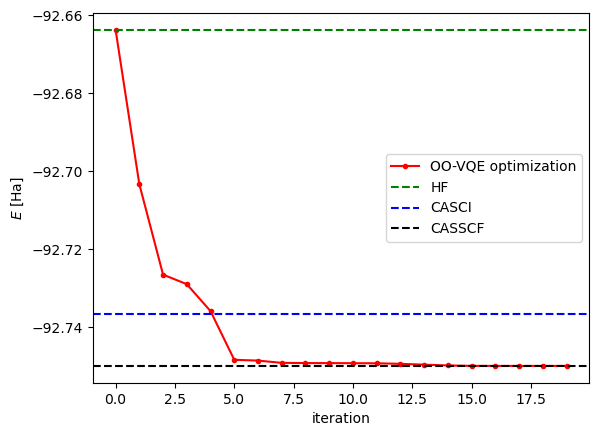

In [40]:
plt.plot(np.append(mol.hf.e_tot, energy_l), '.-r', label='OO-VQE optimization')
plt.axhline(mol.hf.e_tot, ls='--', c='g', label='HF')
plt.axhline(mol.casci.e_tot, ls='--', c='b', label='CASCI')
plt.axhline(mol.casscf.e_tot, ls='--', c='k', label='CASSCF')
plt.xlabel('iteration')
plt.ylabel(r'$E$ [Ha]')
plt.legend()
plt.show()

We see here an important parameter of Newton-Rapshon optimization: the lowest eigenvalue of the Hessian. This determines the rate of convergence. 

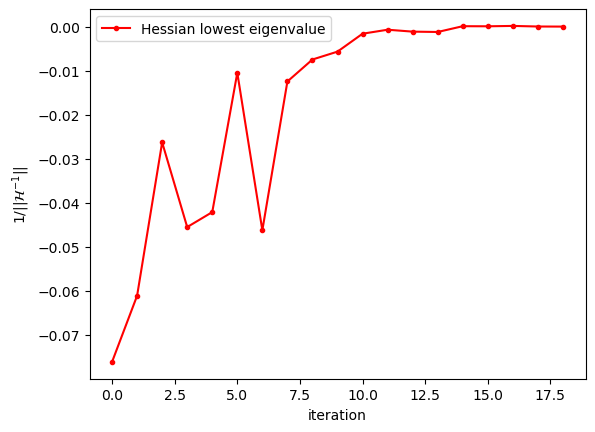

In [41]:
plt.plot(hess_eig_l, '.-r', label='Hessian lowest eigenvalue')
plt.xlabel('iteration')
plt.ylabel(r'$1/||\mathcal{H}^{-1}||$')
plt.legend()
plt.show()

And sometimes the parameters during the optization can be useful:

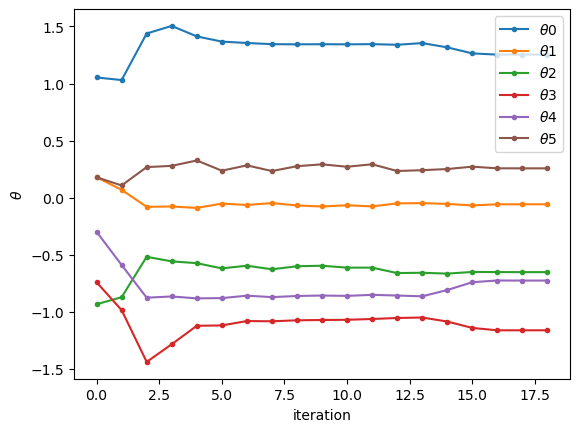

In [42]:
for i in range(len(theta_test)):
    plt.plot([theta_l[j][i] for j in range(len(theta_l))], '.-', label=f'$\\theta {i}$')
plt.xlabel('iteration')
plt.ylabel(r'$\theta$')
plt.legend()
plt.show()